### Level 5 Variables Creation

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
# Load your data
pd.set_option('display.max_columns', None)
dna = pd.read_parquet('dna_pw_20250225.parquet')
dna = dna.drop(columns=['CL_ID2', 'CL_ID4', 'HMO_MEMBER']) # Remove HMO_MEMBER due to insufficient data
dna.head()

,MASKED_ID_NUM,IDV_OCP_TYP_ID,NBR_DPND,GENERATION,GENDER,MARITAL_STATUS,DIGITAL_FLAG,RISK_APPETITE,TRAVELLER,GEODIVERSITY,REGION,HOSPITAL_PAYOR,ENVIRONMENTAL_AFF,HUMANITARIAN_AFF,RELIGIOUS_AFF,FILCHI_CLUB,OF_CLUB,RETIREES_CLUB,MILLENNIAL_CLUB,EXECUTIVES_CLUB,PROFESSIONAL_CLUB,NEW_MERCH_NAME,TXN_AMT_TOT,TXN_AMT_AVE,TXN_CNT,MOST_COMMON_INDUSTRY
0,4016083633,STUDENT,3.0,BOOMERS,FEMALE,MARRIED,TRADITIONAL,AGGRESSIVE,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,N,Y,N,N,IN ROOM DINING,80099.0,14531.0,1.0,Record Stores
1,4016083633,SELFEMPLOYED,3.0,GEN_X,MALE,MARRIED,DIGITAL,AGGRESSIVE,NO_DATA,SINGLE,NATIONAL CAPITAL REGION,LOW,N,N,N,N,Y,Y,N,N,N,VANS 756,41075.0,2753.0,2.0,Drug Stores And Pharmacies
2,4016083633,SELFEMPLOYED,3.0,BOOMERS,FEMALE,MARRIED,DIGITAL,NO_DATA,NO_DATA,DIVERSE,NATIONAL CAPITAL REGION,MID,N,N,N,N,Y,Y,N,N,N,ZHIGUANKEJI,0.0,14504.0,2.0,Grocery Stores And Supermarkets
3,4016083633,EMPLOYED,3.0,BOOMERS,FEMALE,MARRIED,DIGITAL,NO_DATA,NO_DATA,MIGRATORY,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,Y,N,Y,N,ST. LUKE'S MEDICAL CENTER,0.0,5338.0,2.0,Education
4,4016083633,SELFEMPLOYED,3.0,GEN_X,FEMALE,MARRIED,DIGITAL,NO_DATA,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,N,N,N,N,N,NETFLIX,12695.0,0.0,2.0,No Industry Label


In [5]:
print(dna['RISK_APPETITE'].unique())
print(dna['GEODIVERSITY'].unique())
print(dna['DIGITAL_FLAG'].unique())
print(dna['HOSPITAL_PAYOR'].unique())
print(dna['ENVIRONMENTAL_AFF'].unique())

['AGGRESSIVE' 'NO_DATA' 'MODERATELY_CONSERVATIVE' 'MODERATELY_AGGRESSIVE'
 'CONSERVATIVE']
['DIVERSE' 'SINGLE' 'MIGRATORY' 'NO_DATA']
['TRADITIONAL' 'DIGITAL' 'NO_DATA']
['NO_DATA' 'LOW' 'MID' 'HIGH']
['N' 'Y']


#### Data Pre-Processing

In [8]:
risk_mapping = {
    'NO_DATA': -1,  # Assign -1 to indicate missing data
    'CONSERVATIVE': 1,
    'MODERATELY_CONSERVATIVE': 2,
    'MODERATELY_AGGRESSIVE': 3,
    'AGGRESSIVE': 4
}

dna['RISK_APPETITE'] = dna['RISK_APPETITE'].map(risk_mapping)

In [10]:
hospital_payor_mapping = {
    'NO_DATA': -1,  # Assign -1 to indicate missing data
    'LOW': 1,
    'MID': 2,
    'HIGH': 3
}

dna['HOSPITAL_PAYOR'] = dna['HOSPITAL_PAYOR'].map(hospital_payor_mapping)

In [12]:
geodiversity_mapping = {
    'NO_DATA': -1,
    'SINGLE': 1,
    'MIGRATORY': 2,
    'DIVERSE': 3
}

dna['GEODIVERSITY'] = dna['GEODIVERSITY'].map(geodiversity_mapping)

In [14]:
digital_flag_mapping = {
    'NO_DATA': -1,
    'TRADITIONAL': 0,
    'DIGITAL': 1
}

dna['DIGITAL_FLAG'] = dna['DIGITAL_FLAG'].map(digital_flag_mapping)

In [16]:
binary_cols = ['ENVIRONMENTAL_AFF', 'HUMANITARIAN_AFF', 'RELIGIOUS_AFF', 'FILCHI_CLUB', 'OF_CLUB', 
               'RETIREES_CLUB', 'MILLENNIAL_CLUB', 'EXECUTIVES_CLUB', 'PROFESSIONAL_CLUB']

for col in binary_cols:
    dna[col] = dna[col].map({'Y': 1, 'N': 0})

In [18]:
dna = pd.get_dummies(dna, columns=['GENERATION', 'GENDER'], drop_first=True)

In [20]:
dna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85142 entries, 0 to 85141
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MASKED_ID_NUM         85142 non-null  int64  
 1   IDV_OCP_TYP_ID        85142 non-null  object 
 2   NBR_DPND              85142 non-null  float64
 3   MARITAL_STATUS        85142 non-null  object 
 4   DIGITAL_FLAG          85142 non-null  int64  
 5   RISK_APPETITE         85142 non-null  int64  
 6   TRAVELLER             85142 non-null  object 
 7   GEODIVERSITY          85142 non-null  int64  
 8   REGION                85142 non-null  object 
 9   HOSPITAL_PAYOR        85142 non-null  int64  
 10  ENVIRONMENTAL_AFF     85142 non-null  int64  
 11  HUMANITARIAN_AFF      85142 non-null  int64  
 12  RELIGIOUS_AFF         85142 non-null  int64  
 13  FILCHI_CLUB           85142 non-null  int64  
 14  OF_CLUB               85142 non-null  int64  
 15  RETIREES_CLUB      

#### Anomaly Score

In [23]:
# Selecting relevant features (excluding categorical object-type features)
numerical_cols = [
    'NBR_DPND', 'DIGITAL_FLAG', 'RISK_APPETITE', 'GEODIVERSITY', 'HOSPITAL_PAYOR', 
    'ENVIRONMENTAL_AFF', 'HUMANITARIAN_AFF', 'RELIGIOUS_AFF', 'FILCHI_CLUB', 'OF_CLUB',
    'RETIREES_CLUB', 'MILLENNIAL_CLUB', 'EXECUTIVES_CLUB', 'PROFESSIONAL_CLUB', 
    'TXN_AMT_TOT', 'TXN_AMT_AVE', 'TXN_CNT', 'GENERATION_GEN_X', 'GENERATION_GEN_Y', 
    'GENERATION_GEN_Z', 'GENERATION_NO_DATA', 'GENDER_MALE', 'GENDER_UNVERIFIED'
]

In [25]:
# Standardizing numerical columns
scaler = StandardScaler()
dna_scaled = scaler.fit_transform(dna[numerical_cols])

In [27]:
# Fit Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
dna['ANOMALY_SCORE'] = iso_forest.fit_predict(dna_scaled)

# Convert Anomaly_Score: -1 (anomaly) → 1 (outlier), 1 (normal) → 0 (normal)
dna['ANOMALY_SCORE'] = dna['ANOMALY_SCORE'].apply(lambda x: 1 if x == -1 else 0)

# Display the proportion of anomalies detected
print("Number of anomalies detected:", dna['ANOMALY_SCORE'].sum())

Number of anomalies detected: 4258


In [29]:
X_features = dna[['TXN_AMT_TOT', 'TXN_CNT', 'RISK_APPETITE']]  # Use relevant numerical features
silhouette = silhouette_score(X_features, dna['ANOMALY_SCORE'])
print(f'Silhouette Score: {silhouette:.2f}')

Silhouette Score: 0.82


In [31]:
print(dna['ANOMALY_SCORE'].value_counts())

ANOMALY_SCORE
0    80884
1     4258
Name: count, dtype: int64


In [33]:
anomalies = dna[dna['ANOMALY_SCORE'] == 1]
print(anomalies[['MASKED_ID_NUM', 'TXN_AMT_TOT', 'TXN_CNT', 'RISK_APPETITE']].head(10))

     MASKED_ID_NUM  TXN_AMT_TOT  TXN_CNT  RISK_APPETITE
14      6838321487     101834.0     12.0             -1
17      6838321487          0.0      2.0             -1
32      2153446108      37181.0      1.0              3
39      2153446108     108417.0      2.0              4
59       959165105          0.0     15.0             -1
65      1813063147    3373003.0     13.0             -1
67      1813063147          0.0      1.0             -1
73      1813063147          0.0      2.0              4
121     8961389524      48101.0      1.0              4
177     8961389524      26914.0      2.0             -1


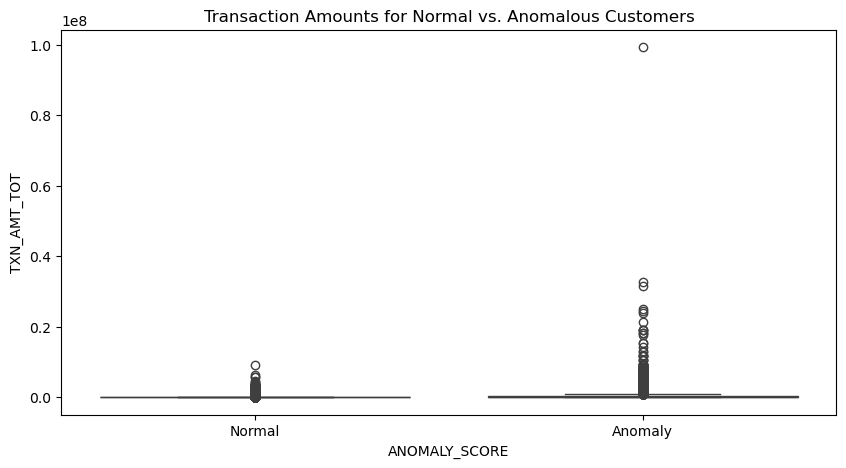

In [35]:
plt.figure(figsize=(10,5))
sns.boxplot(x=dna['ANOMALY_SCORE'], y=dna['TXN_AMT_TOT'])
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.title('Transaction Amounts for Normal vs. Anomalous Customers')
plt.show()

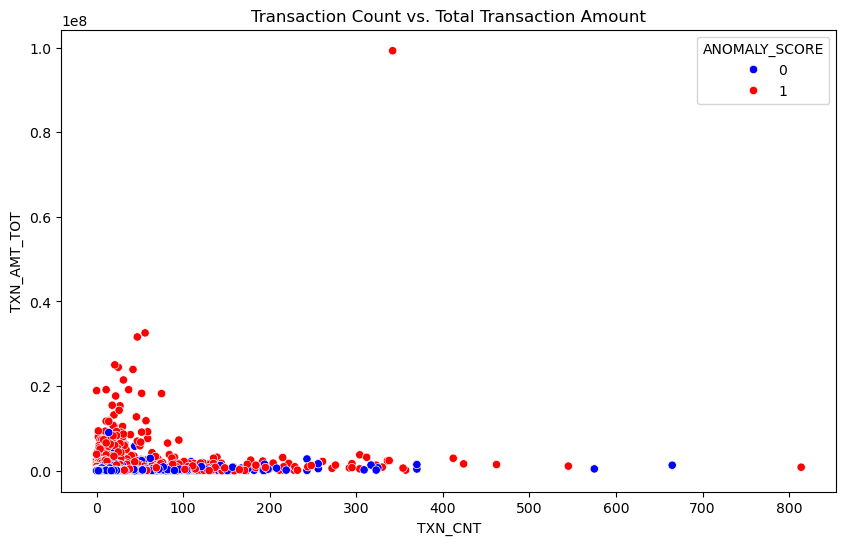

In [37]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=dna['TXN_CNT'], y=dna['TXN_AMT_TOT'], hue=dna['ANOMALY_SCORE'], palette={0: 'blue', 1: 'red'})
plt.title('Transaction Count vs. Total Transaction Amount')
plt.show()

In [39]:
dna.to_csv("dna_with_anomaly_scores.csv", index=False)